# Modelo detección de fraude biométrico en proceso de onboarding digital

## Cuaderno de integración modelos individuales

### Descripción:
Este cuaderno permite probar que los modelos individuales esten funcionando, para luego calcular el orden óptimo de ejecución en función de las pruebas cruzadas de los modelos versus los distintos tipos de fraude.
Después de determinada la cañería, se prueba usando un set de datos que reproduce las proporciones de los distintos tipos de fraude


#### Dependencias 

In [1]:
from PIL import Image

import sys
sys.path.append('../src/')  

from CLASE_0 import FaceVerifier
from CLASE_I import AgeChecker
from CLASE_II_IV import Fake_II_IV_detector
from CLASE_III_A  import Fake_III_A_detector
from CLASE_III_B  import Fake_III_B_detector


import matplotlib.pyplot as plt

import os
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

import numpy as np
from gurobipy import Model, GRB

import warnings
warnings.filterwarnings('ignore')

#### Rutas a modelos e imágenes

In [2]:
paths = {
    'predictor_path'        : "../modelos/shape_predictor_68_face_landmarks.dat",
    'face_rec_model_path'   : "../modelos/dlib_face_recognition_resnet_model_v1.dat",
    'model_weights_path'    : "../modelos/weights.pt",
    
    'model_II_IV_path'      : "../modelos/CLASE_II_IV_Random_forest.joblib",
    'model_III_A_path'      : "../modelos/CLASE_III_A_CNN.h5",
    'model_III_B_path'      : "../modelos/CLASE_III_B_CNN.h5",

    'img_Prueba_ID'         : "../data/pruebas/demos/ID_0.png",
    'img_Prueba_VAL_OK'     : "../data/pruebas/demos/VAL_0.png",
    'img_Prueba_VAL_NOK'    : "../data/pruebas/demos/VAL_1.png",
    'img_Prueba_ID_M'       : "../data/pruebas/demos/ID_98.png",
    'img_Prueba_ID_FK_II'   : "../data/pruebas/demos/ID_FAKE_II_8.png",
    'img_Prueba_ID_FK_IVA'  : "../data/pruebas/demos/ID_FAKE_IV_A_1.png",
    'img_Prueba_ID_FK_III_A': "../data/pruebas/demos/ID_FAKE_III_A_DEMO.png",
    'img_Prueba_ID_FK_III_B': "../data/pruebas/demos/ID_FAKE_III_B_DEMO.png",

 
    'carpeta_true'          : "../data/pruebas/positivos",
    'carpeta_false'         : "../data/pruebas/negativos"



}



#### Parámetros para modelos

In [3]:
#Parámetro CASO_0
threshold_identidad = 0.65
#Parámetro CASO_1
threshold_edad = 21


#### Creación instancias modelos individuales

In [4]:
Modelo_CLASE_0 = FaceVerifier(paths['predictor_path'], paths['face_rec_model_path'], threshold_identidad)
Modelo_CLASE_I = AgeChecker(paths['model_weights_path'], threshold_edad)
Modelo_CLASE_II_IV = Fake_II_IV_detector(paths['model_II_IV_path'])
Modelo_CLASE_III_A = Fake_III_A_detector(model_path=paths['model_III_A_path'], predictor_path=paths['predictor_path'])
Modelo_CLASE_III_B = Fake_III_B_detector(model_path=paths['model_III_B_path'], predictor_path=paths['predictor_path'])

Weights loaded successfully from path: ../modelos/weights.pt


#### Pruebas iniciales, permiten validar que los modelos individuales operen correctamente

In [5]:

image_id_real = Image.open(paths['img_Prueba_ID'])
image_id_VAL_OK = Image.open(paths['img_Prueba_VAL_OK'])
image_id_VAL_NOK = Image.open(paths['img_Prueba_VAL_NOK'])
image_id_M = Image.open(paths['img_Prueba_ID_M'])
image_id_FK_II = Image.open(paths['img_Prueba_ID_FK_II'])
image_id_FK_IV = Image.open(paths['img_Prueba_ID_FK_IVA'])
image_id_FK_III_A = Image.open(paths['img_Prueba_ID_FK_III_A'])
image_id_FK_III_B = Image.open(paths['img_Prueba_ID_FK_III_B'])





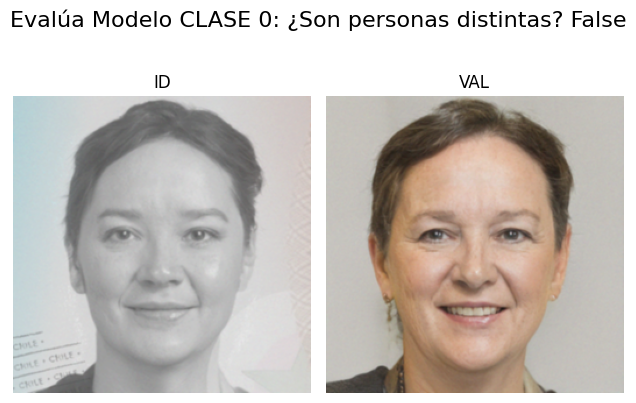

In [6]:
fig, axes = plt.subplots(1, 2) 

axes[0].imshow(image_id_real)
axes[0].axis('off')  
axes[0].set_title("ID") 

axes[1].imshow(image_id_VAL_OK)
axes[1].axis('off')
axes[1].set_title("VAL")  


fig.suptitle(f'Evalúa Modelo CLASE 0: ¿Son personas distintas? {Modelo_CLASE_0.verify_faces(image_id_real, image_id_VAL_OK)}', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  
plt.show()


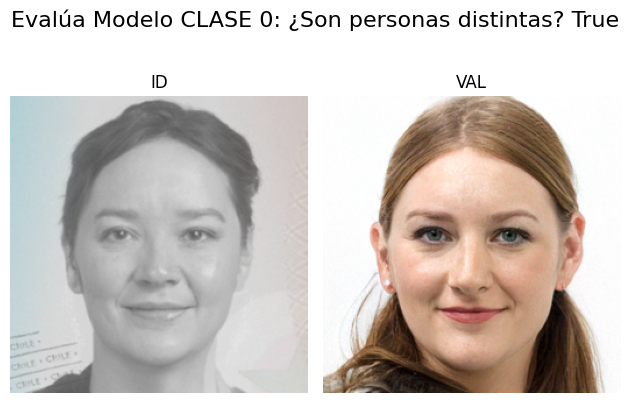

In [7]:
fig, axes = plt.subplots(1, 2) 

axes[0].imshow(image_id_real)
axes[0].axis('off')  
axes[0].set_title("ID") 

axes[1].imshow(image_id_VAL_NOK)
axes[1].axis('off')
axes[1].set_title("VAL")  


fig.suptitle(f'Evalúa Modelo CLASE 0: ¿Son personas distintas? {Modelo_CLASE_0.verify_faces(image_id_real, image_id_VAL_NOK)}', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  
plt.show()

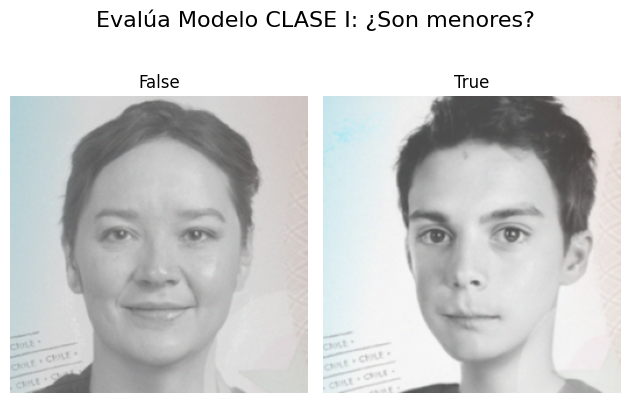

In [8]:
fig, axes = plt.subplots(1, 2) 

axes[0].imshow(image_id_real)
axes[0].axis('off')  
axes[0].set_title(f"{Modelo_CLASE_I.is_minor(image_id_real)}") 

axes[1].imshow(image_id_M)
axes[1].axis('off')
axes[1].set_title(f"{Modelo_CLASE_I.is_minor(image_id_M)}")   


fig.suptitle(f'Evalúa Modelo CLASE I: ¿Son menores?', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  
plt.show()

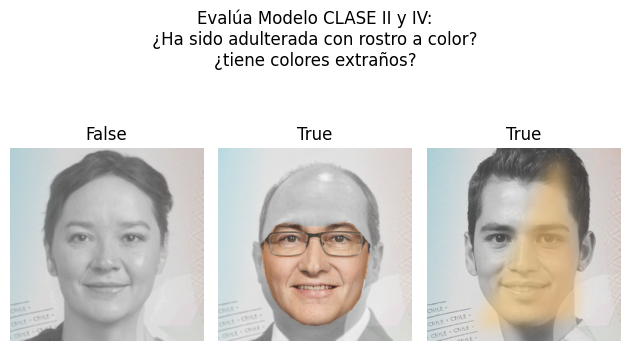

In [9]:
fig, axes = plt.subplots(1, 3) 

axes[0].imshow(image_id_real)
axes[0].axis('off')  
axes[0].set_title(f"{Modelo_CLASE_II_IV.predict(image_id_real)}") 

axes[1].imshow(image_id_FK_II)
axes[1].axis('off')
axes[1].set_title(f"{Modelo_CLASE_II_IV.predict(image_id_FK_II)}")   

axes[2].imshow(image_id_FK_IV)
axes[2].axis('off')
axes[2].set_title(f"{Modelo_CLASE_II_IV.predict(image_id_FK_IV)}")   


fig.suptitle(f'Evalúa Modelo CLASE II y IV:\n ¿Ha sido adulterada con rostro a color? \n¿tiene colores extraños?', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.95) 
plt.show()

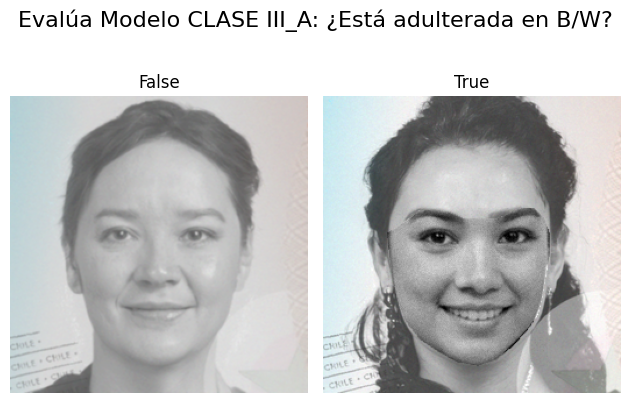

In [10]:
fig, axes = plt.subplots(1, 2) 

axes[0].imshow(image_id_real)
axes[0].axis('off')  
axes[0].set_title(f"{Modelo_CLASE_III_A.predict(image_id_real)}") 

axes[1].imshow(image_id_FK_III_A)
axes[1].axis('off')
axes[1].set_title(f"{Modelo_CLASE_III_A.predict(image_id_FK_III_A)}")   


fig.suptitle(f'Evalúa Modelo CLASE III_A: ¿Está adulterada en B/W?', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95) 
plt.show()

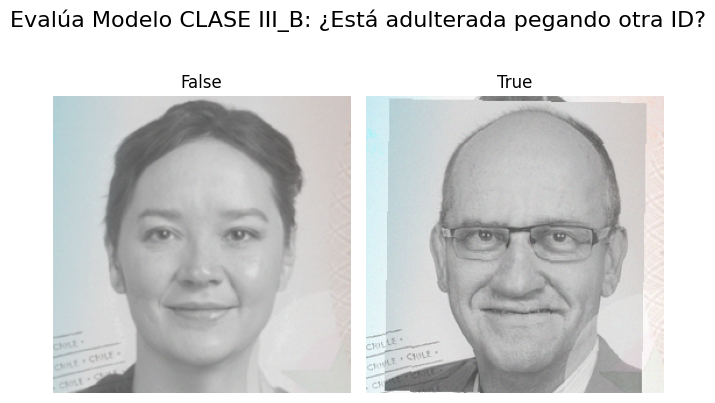

In [11]:
fig, axes = plt.subplots(1, 2) 

axes[0].imshow(image_id_real)
axes[0].axis('off')  
axes[0].set_title(f"{Modelo_CLASE_III_B.predict(image_id_real)}") 

axes[1].imshow(image_id_FK_III_B)
axes[1].axis('off')
axes[1].set_title(f"{Modelo_CLASE_III_B.predict(image_id_FK_III_B)}")   


fig.suptitle(f'Evalúa Modelo CLASE III_B: ¿Está adulterada pegando otra ID?', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95) 
plt.show()

## Determinación del orden óptimo para ejecutar los modelos en la cañería

##### Variables de decisión:

$x_{j}$: Variable binaria que indica si se utiliza el Modelo $j$

##### Parámetros:

**$F_i$ :** Frecuencia de ocurrencia del fraude tipo $i$.        
**$TFN_{ij}$:** Probabilidad de no detectar un tipo de fraude $i$ por parte del modelo $j$     
**$TFP_{ij}$:** Probabilidad de detectar erróneamente un tipo de fraude $i$ por parte del modelo $j$             
**$C_f$:** Pérdida promedio por fraude no detectado.    
**$P_{perdida}$:** Porcentaje de clientes que se pierden cuando son identificados erróneamente.   
**$C_{op}$:** Pérdida promedio por cliente perdido.    


##### Función objetivo:

$\min Z =\sum_{i} \sum_{j} x_{j} \cdot (F_i \cdot (C_f \cdot TFN_{ij} + P_{perdida} \cdot C_{op} \cdot TFP_{ij}))  $

##### Sujeto a:

**Se debe seleccionar sólo un modelo**    
         
$\sum_{j} X_j = 1$





#### Planteo del problema

El foco del desarrollo tiene relación con minimizar las pérdidas en el proceso de on boarding, sea por el costo de oportunidad o por fraude.
La función objetivo representa esto mediante la evaluación del costo de los fraudes no detectados y los Falsos Positivos (pérdida por costo de oportunidad). Para la evaluación se considera la probabilidad de cada tipo de fraude, la probabilidad de perder el cliente y el costo de ambas alternativas.

#### **La implementación de los clasificadores se realizará como una secuencia (cañería) donde, al primer positivo de fraude, se envía al cliente a tienda. Dado esto, el orden en que se usan los clasificadores es muy importante.** 

Por otro lado, **implementar el problema en términos de optimización no es trivial, en particular porque el cálculo de la función objetivo debiera ser capaz de incluir el hecho que los clasificadores se dejan de ejecutar al determinar un caso positivo.**. Sin embargo, lo que ese busca es un orden que minimice el costo hasta el punto donde se detecta un fraude, por lo que esto puede plantearse como una optimización en secuencia, donde los modelos de clasificación deben ejecutarse de menor a mayor respecto de su costo, lo que garantiza que, sea cual sea el modelo que identifique el fraude, siempre es manteniendo el mejor equilibrio entre detección y falsos positivos.


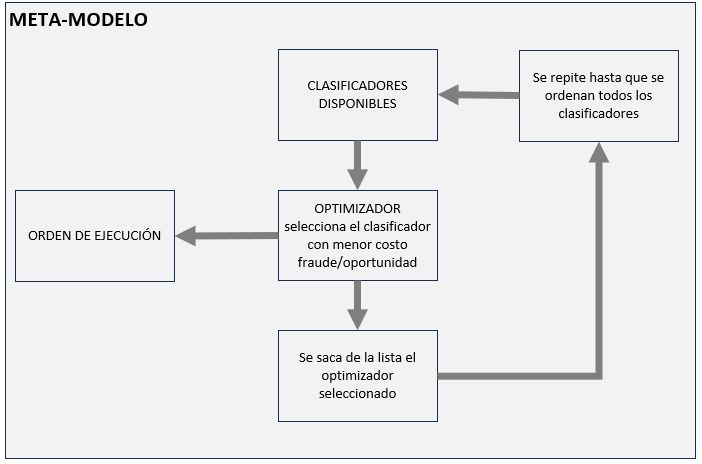


El costo de cada clasificador, se definió para cada modelo $j$ considerando la probabilidad de no detectar un fraude (Falso Negativo) versus detectar erróneamente a alguien (Falso Positivo) en función de la frecuencia del tipo de fraude específico $i$ :    
    
$Z = F_i \cdot (C_f \cdot TFN_{ij} + P_{perdida} \cdot C_{op} \cdot TFP_{ij})$


## Datos a usar para el presente escenario.

Los indicadores se calculan en cuaderno adjunto y se cargan acá.

 <style>
  .small-table table {
    font-size: 0.9em; /* Reduce el tamaño de la fuente */
    width: auto !important; /* Ajusta el ancho automáticamente */
  }
  .small-table th, .small-table td {
    padding: 2px 5px; /* Reduce el padding de las celdas para un aspecto más comprimido */
  }
</style>

<div class="small-table">

| Tipo de fraude $i$ | Modelo                                              | Frecuencia $F_i$ | TFN_M0 | TFN_MI | TFN_MII | TFN_MIIIA | TFN_MIIIB | TFN_MIV | TFP_M0 | TFP_MI | TFP_MII | TFP_MIIIA |
|--------------------|-----------------------------------------------------|------------------|--------|--------|---------|-----------|-----------|---------|--------|--------|---------|-----------|
| 0                  | Compara rostros ID/Foto                             | $F_{0}=23.4\%$   | 29,3%  | 100,0% | 100,0%  | 100,0%    | 100,0%    | 100,0%  | 7,1%   | 0,0%   | 0,0%    | 0,0%      |
| I                  | Estima si edad es mayor a 18 años                   | $F_{I}=6.4\%$    | 100,0% | 21,3%  | 100,0%  | 100,0%    | 100,0%    | 100,0%  | 0,0%   | 10,2%  | 0,0%    | 0,0%      |
| II                 | Detecta adulteración: pegado de foto color sobre ID | $F_{II}=17.0\%$  | 100,0% | 100,0% | 0,0%    | 3,4%      | 99,9%     | 0,0%    | 0,0%   | 0,0%   | 2,3%    | 3,0%      |
| III-A              | Detecta adulteración: pegado de foto gris sobre ID  | $F_{III}=14.4\%$ | 100,0% | 100,0% | 0,8%    | 1,4%      | 98,2%     | 95,7%   | 0,0%   | 0,0%   | 1,1%    | 1,1%      |
| III-B              | Detecta adulteración: ID sobre ID                   | $F_{III}=14.3\%$ | 100,0% | 100,0% | 94,0%   | 99,9%     | 2,6%      | 94,0%   | 0,0%   | 0,0%   | 2,3%    | 0,1%      |
| IV                 | Detecta colores inusuales en ID                     | $F_{IV}=24.5\%$  | 100,0% | 100,0% | 1,9%    | 93,2%     | 99,9%     | 1,9%    | 0,0%   | 0,0%   | 2,3%    | 3,0%      |


</div>


Respecto de las pérdidas promedio se consideran:            
$C_f$ = $ 250 000 (promedio anual por fraude)                 
$C_{op}$ = $ 1 100 000 (costo de oportunidad)              


Con una probabilidad de perder un cliente de $P_p$ 55% 



### Prueba del optimizador con un paso

In [12]:
m = Model("deteccion_fraude")

F = {'0': 0.234, 'I': 0.064, 'II': 0.17, 'IIIA': 0.144, 'IIIB': 0.143, 'IV': 0.245}
TFN = {
    '0':    {'M0': 0.293, 'MI': 1.00 , 'MII': 1.00 , 'MIIIA': 1.00 ,'MIIIB': 1.00 , 'MIV': 1.00 },
    'I':    {'M0': 1.00 , 'MI': 0.213, 'MII': 1.00 , 'MIIIA': 1.00 ,'MIIIB': 1.00 , 'MIV': 1.00 },
    'II':   {'M0': 1.00 , 'MI': 1.00 , 'MII': 0.0  , 'MIIIA': 0.034,'MIIIB': 0.999, 'MIV': 0.00 },
    'IIIA': {'M0': 1.00 , 'MI': 1.00 , 'MII': 0.008, 'MIIIA': 0.014,'MIIIB': 0.982 , 'MIV': 0.957},
    'IIIB': {'M0': 1.00 , 'MI': 1.00 , 'MII': 0.940, 'MIIIA': 0.999,'MIIIB': 0.026, 'MIV': 0.94},   
    'IV':   {'M0': 1.00 , 'MI': 1.00 , 'MII': 0.019, 'MIIIA': 0.932,'MIIIB': 0.999, 'MIV': 0.019}
}
TFP = {
    '0':    {'M0': 0.07, 'MI': 0.00 , 'MII': 0.00 , 'MIIIA': 0.00 ,'MIIIB': 0.00 , 'MIV': 0.00 },
    'I':    {'M0': 0.00 , 'MI': 0.102, 'MII': 0.00 , 'MIIIA': 0.00 ,'MIIIB': 0.00 , 'MIV': 0.00 },
    'II':   {'M0': 0.00 , 'MI': 0.00 , 'MII': 0.023, 'MIIIA': 0.03 ,'MIIIB': 0.00 , 'MIV': 0.023},
    'IIIA': {'M0': 0.00 , 'MI': 0.00 , 'MII': 0.011, 'MIIIA': 0.011,'MIIIB': 0.01 , 'MIV': 0.011},
    'IIIB': {'M0': 0.00 , 'MI': 0.00 , 'MII': 0.023, 'MIIIA': 0.00 ,'MIIIB': 0.00 , 'MIV': 0.023},    
    'IV':   {'M0': 0.00 , 'MI': 0.00 , 'MII': 0.023, 'MIIIA': 0.03 ,'MIIIB': 0.00 , 'MIV': 0.023}
}
C_f = 250000  
P_perdida = 0.55 
C_op = 1100000


modelos = ['M0', 'MI', 'MII', 'MIIIA', 'MIIIB', 'MIV']
x = m.addVars(modelos, vtype=GRB.BINARY, name="x")


m.setObjective(
    sum(x[j] * (F[i] * (C_f * TFN[i][j] + P_perdida * C_op * TFP[i][j]))
        for i in F for j in modelos), 
    GRB.MINIMIZE
)


m.addConstr(sum(x[j] for j in modelos) >= 1, "seleccion_modelo")

m.update()
m.display()

Restricted license - for non-production use only - expires 2025-11-24
Minimize
218550.4 x[M0] + 241357.44 x[MI] + 118279.64 x[MII] + 177738.82 x[MIIIA]
+ 215298.95 x[MIIIB] + 152443.63999999998 x[MIV]
Subject To
  seleccion_modelo: x[M0] + x[MI] + x[MII] + x[MIIIA] + x[MIIIB] + x[MIV] >= 1
Binaries
  ['x[M0]', 'x[MI]', 'x[MII]', 'x[MIIIA]', 'x[MIIIB]', 'x[MIV]']


In [13]:
m.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0x2141dfd1
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+05, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 152443.64000
Presolve removed 1 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 32 available processors)

Solution count 2: 118280 152444 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.182796400000e+05, best bound 1.182796400000e+05, gap 0.0000%


In [14]:

if m.status == GRB.Status.OPTIMAL:
    print("De los modelos disponibles el que tiene el menor costo asociado es el ")
    for j in modelos:
        if x[j].X > 0.5:
            print(f"Modelo {j}, el cual presenta un costo de {m.objVal}")
else:
    print("No se encontró solución óptima.")


De los modelos disponibles el que tiene el menor costo asociado es el 
Modelo MII, el cual presenta un costo de 118279.64


### Implementación del META-MODELO

In [15]:
def resolver_modelo(TFN_i, TFP_i, modelos_i, F_i, C_f, P_perdida, C_op):
    TFN=TFN_i.copy()
    TFP =TFP_i.copy()
    modelos=modelos_i.copy()
    F=F_i.copy()

        
    
    m = Model("deteccion_fraude")

    x = m.addVars(modelos, vtype=GRB.BINARY, name="x")

    m.setObjective(
        sum(x[j] * (F[i] * (C_f * TFN[i][j] + P_perdida * C_op * TFP[i][j]))
            for i in F for j in modelos), 
        GRB.MINIMIZE
    )

    m.addConstr(sum(x[j] for j in modelos) >= 1, "seleccion_modelo")

    m.optimize()

    solucion = {}
    if m.status == GRB.Status.OPTIMAL:
        for j in modelos:
            if x[j].X > 0.5:
                solucion[j] = m.objVal
                break
    return solucion

def meta_modelo(TFN_i, TFP_i, modelos_i, F_i, C_f, P_perdida, C_op):
    TFN=TFN_i.copy()
    TFP =TFP_i.copy()
    modelos=modelos_i.copy()
    F=F_i.copy()
    
    
    
    resultados = []
    while modelos:

        solucion = resolver_modelo(TFN, TFP, modelos, F, C_f, P_perdida, C_op)

        for modelo_seleccionado, valor_obj in solucion.items():
            resultados.append((modelo_seleccionado, valor_obj))
            for i in F:
                TFN[i][modelo_seleccionado] = 1
                TFP[i][modelo_seleccionado] = 1


            modelos.remove(modelo_seleccionado)
    return resultados


In [16]:
resultados= meta_modelo(TFN, TFP, modelos, F, C_f, P_perdida, C_op)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0x2141dfd1
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+05, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 152443.64000
Presolve removed 1 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 32 available processors)

Solution count 2: 118280 152444 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.182796400000e+05, best bound 1.182796400000e+05, gap 0.0000%
Gurobi Optimizer version 11.0.1 build v11.

### Para equilibrar los modelos en su capacidad de detectar los distintos tipos de fraude, versus el riesgo de los falsos positivos se recomienda implementarlos en el siguiente orden

In [17]:
print("Orden de selección de modelos desde el mejor al peor:")
for modelo, valor in resultados:
    print(f"Modelo: {modelo}, Valor objetivo: {valor}")


Orden de selección de modelos desde el mejor al peor:
Modelo: MII, Valor objetivo: 118279.64
Modelo: MIV, Valor objetivo: 152443.63999999998
Modelo: MIIIA, Valor objetivo: 177738.82
Modelo: MIIIB, Valor objetivo: 215298.95
Modelo: M0, Valor objetivo: 218550.4
Modelo: MI, Valor objetivo: 241357.44


Con los resultados del orden óptimo, se implementa la cañería de evaluación. Dado que cada modelo es independiente, es muy simple actualizar el orden o agregar nuevos modelos.

In [18]:
def pipeline_evaluacion(img_ID,img_VAL):
    
    if Modelo_CLASE_II_IV.predict(img_ID):
        return True    


    if Modelo_CLASE_III_A.predict(img_ID):
        return True

    if Modelo_CLASE_III_B.predict(img_ID):
        return True

   
    if Modelo_CLASE_0.verify_faces(img_ID, img_VAL):
        return True  

    if Modelo_CLASE_I.is_minor(img_ID):
        return True  

    return False


### Prueba de la cañería

In [19]:
pipeline_evaluacion(image_id_real, image_id_VAL_NOK)



True

### Evaluación de la cañería con un set de prueba

In [20]:

def cargar_imagenes(carpeta_base, verdad):
    imagenes_id = []
    imagenes_val = []
    etiquetas = []
    nombres_archivos = []  

    ruta_id = os.path.join(carpeta_base, "ID")
    ruta_val = os.path.join(carpeta_base, "VAL")

    archivos_id = sorted([f for f in os.listdir(ruta_id) if f.endswith('.png')])
    archivos_val = sorted([f for f in os.listdir(ruta_val) if f.endswith('.png')])

    for archivo_id, archivo_val in zip(archivos_id, archivos_val):
        imagen_id = Image.open(os.path.join(ruta_id, archivo_id))
        imagen_val = Image.open(os.path.join(ruta_val, archivo_val))
        imagenes_id.append(imagen_id)
        imagenes_val.append(imagen_val)
        etiquetas.append(verdad)
        nombres_archivos.append((archivo_id, archivo_val))  

    return imagenes_id, imagenes_val, etiquetas, nombres_archivos


def evaluar_modelo(imagenes_id, imagenes_val, etiquetas_verdaderas, nombres_archivos):
    predicciones = []
    for imagen_id, imagen_val in zip(imagenes_id, imagenes_val):
        resultado = pipeline_evaluacion(imagen_id, imagen_val)
        predicciones.append(resultado)

    accuracy = accuracy_score(etiquetas_verdaderas, predicciones)
    f1 = f1_score(etiquetas_verdaderas, predicciones, zero_division=1)
    confusion = confusion_matrix(etiquetas_verdaderas, predicciones).ravel()
    tn, fp, fn, tp = confusion

    error_tipo_i = fp / (fp + tn) if (fp + tn) != 0 else 0
    error_tipo_ii = fn / (fn + tp) if (fn + tp) != 0 else 0



    return {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Error Tipo I (%)": error_tipo_i * 100,
        "Error Tipo II (%)": error_tipo_ii * 100
    }


In [21]:

imagenes_id_true, imagenes_val_true, etiquetas_true, nombres_archivos_true = cargar_imagenes(paths['carpeta_true'], True)
imagenes_id_false, imagenes_val_false, etiquetas_false, nombres_archivos_false = cargar_imagenes(paths['carpeta_false'], False)


imagenes_id = imagenes_id_true + imagenes_id_false
imagenes_val = imagenes_val_true + imagenes_val_false
etiquetas_verdaderas = etiquetas_true + etiquetas_false
nombres_archivos = nombres_archivos_true + nombres_archivos_false



In [22]:
resultados = evaluar_modelo(imagenes_id, imagenes_val, etiquetas_verdaderas, nombres_archivos)
print(resultados)


{'Accuracy': 0.9233409610983981, 'F1 Score': 0.93488824101069, 'Error Tipo I (%)': 12.834224598930483, 'Error Tipo II (%)': 3.8}
